In [1]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd
import torch
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import torch.optim as optim
from pprint import pprint
from tqdm import tqdm

from MatrixVectorizer import MatrixVectorizer
from preprocessing import antivectorize_df
from model import GSRNet, Discriminator
from train import train_gan, test_gan
from utils import track_memory, get_device, compute_degree_matrix_normalization_batch_numpy, get_parser, evaluate, plot_metrics_fold, LR_size, HR_size

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

mps


# Import Data

In [3]:
# A_LR_train = pd.read_csv("../data/lr_train.csv")
# A_HR_train = pd.read_csv("../data/hr_train.csv")
# A_LR_test = pd.read_csv("../data/lr_test.csv")

# np.save('A_LR_train_matrix.npy', antivectorize_df(A_LR_train, LR_size))
# np.save('A_HR_train_matrix.npy', antivectorize_df(A_HR_train, HR_size))
# np.save('A_LR_test_matrix.npy', antivectorize_df(A_LR_test, LR_size))

In [4]:
A_LR_train_matrix = np.load('A_LR_train_matrix.npy')
A_HR_train_matrix = np.load('A_HR_train_matrix.npy')
A_LR_test_matrix = np.load("A_LR_test_matrix.npy")

print(A_LR_train_matrix.shape)
print(A_HR_train_matrix.shape)
print(A_LR_test_matrix.shape)

(167, 160, 160)
(167, 268, 268)
(112, 160, 160)


# Parameters

In [5]:
parser = get_parser()
# Create an empty Namespace to hold the default arguments
args = parser.parse_args([])
pprint(args.__dict__)

{'dropout_rate': 0.2,
 'early_stop_patient': 5,
 'embedding_size': 32,
 'epochs': 2,
 'hidden_dim': 268,
 'hr_dim': 268,
 'ks': [0.9, 0.7, 0.6, 0.5],
 'lmbda': 24,
 'lr': 0.00010436239086997339,
 'lr_dim': 160,
 'mean_dense': 0.0,
 'mean_gaussian': 0.0,
 'padding': 26,
 'splits': 3,
 'std_dense': 0.01,
 'std_gaussian': 0.1}


In [6]:
# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
X = A_LR_train_matrix  # np.random.normal(0, 0.5, (167, 160, 160))
Y = A_HR_train_matrix  # np.random.normal(0, 0.5, (167, 288, 288))
print(X.shape)
print(Y.shape)

(167, 160, 160)
(167, 268, 268)


In [7]:
X = compute_degree_matrix_normalization_batch_numpy(X)
A_LR_test_matrix = compute_degree_matrix_normalization_batch_numpy(A_LR_test_matrix)
print(X.shape)

(167, 160, 160)


# K-Fold Cross Validation

In [8]:
cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

best_model_fold_list = []
data_fold_list = []
i = 1
for train_index, test_index in cv.split(X):

    print(f"----- Fold {i} -----")

    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = (
        X[train_index],
        X[test_index],
        Y[train_index],
        Y[test_index],
    )
    data_fold_list.append(
        (subjects_adj, test_adj, subjects_ground_truth, test_ground_truth)
    )

    netG = GSRNet(args).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

    netD = Discriminator(args).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    track_memory()
    # GAN model
    return_model = train_gan(
        netG,
        optimizerG,
        netD,
        optimizerD,
        subjects_adj,
        subjects_ground_truth,
        args,
        test_adj=test_adj,
        test_ground_truth=test_ground_truth,
    )
    track_memory()

    test_mae = test_gan(return_model, test_adj, test_ground_truth, args)
    train_mae = test_gan(return_model, subjects_adj, subjects_ground_truth, args)
    print(f"Train MAE: {train_mae:.6f}, Val MAE: {test_mae:.6f}")
    best_model_fold_list.append(return_model)

    i += 1

----- Fold 1 -----
Current memory usage: 704.59 MB
inside train_gan
Creating mask for upper triangular matrix...
Training GAN


Epoch Progress:   0%|          | 0/2 [00:00<?, ?epoch/s]

Epoch 1/2


/Users/carlosbrat/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/Deep Graph-based Learning/CW2/graph_super_resolution/gsr_net/layers.py:27: UserWarning: The operator 'aten::_linalg_eigh.eigenvalues' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO="U")


Epoch 2/2
Val Error: 0.198821
Current memory usage: 1014.55 MB
Train MAE: 0.204650, Val MAE: 0.198821
----- Fold 2 -----
Current memory usage: 1142.12 MB
inside train_gan
Creating mask for upper triangular matrix...
Training GAN


Epoch Progress:   0%|          | 0/2 [00:00<?, ?epoch/s]

Epoch 1/2
Epoch 2/2
Val Error: 0.201981
Current memory usage: 1150.83 MB
Train MAE: 0.196046, Val MAE: 0.201981
----- Fold 3 -----
Current memory usage: 1276.11 MB
inside train_gan
Creating mask for upper triangular matrix...
Training GAN


Epoch Progress:   0%|          | 0/2 [00:00<?, ?epoch/s]

Epoch 1/2
Epoch 2/2
Val Error: 0.202423
Current memory usage: 1285.12 MB
Train MAE: 0.201569, Val MAE: 0.202423


In [9]:
CAL_GRAPH = False

res_list = []

for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()
    pred_matrices = np.zeros(gt_matrices.shape)
    with torch.no_grad():
        for j, test_adj in enumerate(test_adjs):
            pred = model(torch.from_numpy(test_adj))[0]
            pred = torch.clamp(pred, min=0.0, max=1.0)
            pred = pred.cpu()
            pred_matrices[j] = pred
    res_list.append(evaluate(pred_matrices, gt_matrices, cal_graph=CAL_GRAPH))

pd.DataFrame(res_list)

100%|██████████| 56/56 [00:00<00:00, 125.44it/s]


MAE:  0.19885008523788628
PCC:  0.2560424411703547
Jensen-Shannon Distance:  0.37746090953726175


100%|██████████| 56/56 [00:00<00:00, 130.58it/s]


MAE:  0.20198078931243243
PCC:  0.24581271853863546
Jensen-Shannon Distance:  0.37846189248964673


100%|██████████| 55/55 [00:00<00:00, 132.88it/s]


MAE:  0.20242332975105568
PCC:  0.24488552479943115
Jensen-Shannon Distance:  0.37754427058160117


,MAE,PCC,JSD
0,0.198850,0.256042,0.377461
1,0.201981,0.245813,0.378462
2,0.202423,0.244886,0.377544


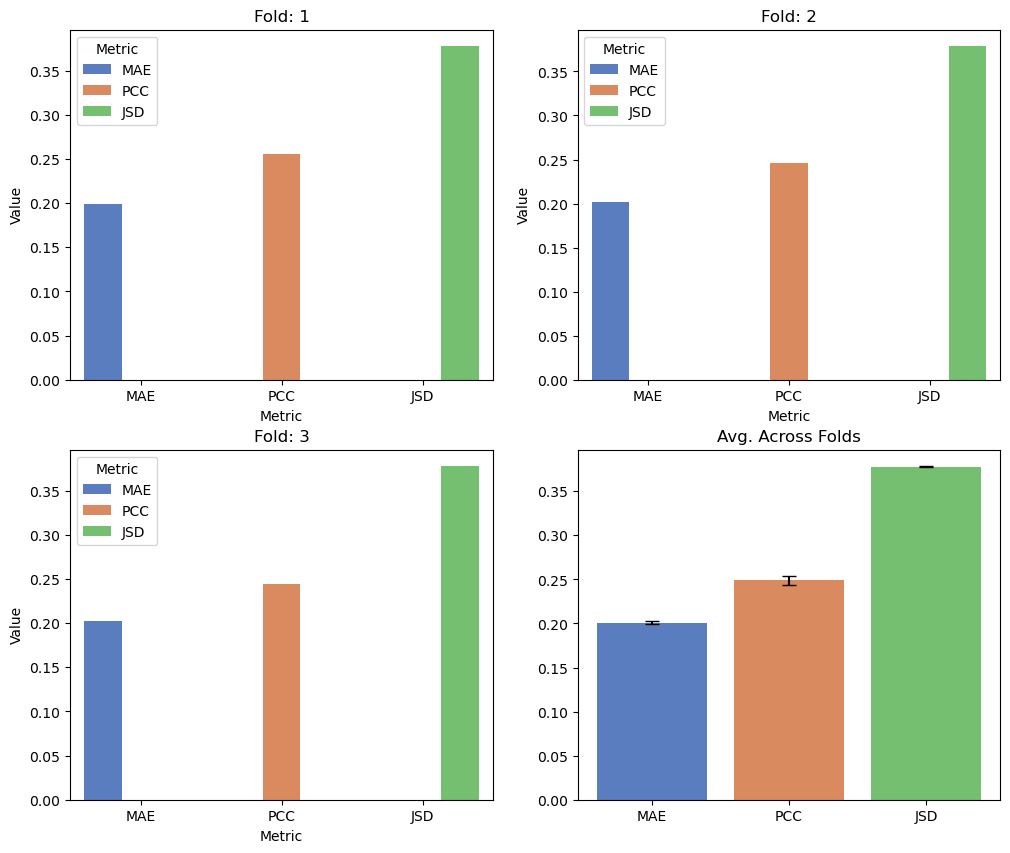

In [10]:
plot_metrics_fold(res_list)

In [11]:
for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()

    output_pred_list = []
    with torch.no_grad():
        for test_adj in tqdm(test_adjs):
            output_pred = model(torch.from_numpy(test_adj))[0].cpu()
            output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
            output_pred_list.append(output_pred)

    output_pred_stack = np.stack(output_pred_list, axis=0)
    output_pred_1d = output_pred_stack.flatten()

    df = pd.DataFrame(
        {
            "ID": [i + 1 for i in range(len(output_pred_1d))],
            "Predicted": output_pred_1d.tolist(),
        }
    )

    df.to_csv("predictions_fold_" + str(i + 1) + ".csv", index=False)

100%|██████████| 55/55 [00:09<00:00,  6.01it/s]


# Final Model

In [12]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(f"HR Train PCA shape: {A_HR_train_pca.shape}")

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

X = np.load("A_LR_train_matrix.npy")
y = np.load("A_HR_train_matrix.npy")

X = compute_degree_matrix_normalization_batch_numpy(X)

n_sample = X.shape[0]
X_train, X_val, y_train, y_val = train_test_split(
    X.reshape(n_sample, -1),
    y.reshape(n_sample, -1),
    test_size=0.10,
    random_state=random_seed,
    stratify=A_HR_train_label,
)

X_train = X_train.reshape(-1, LR_size, LR_size)
X_val = X_val.reshape(-1, LR_size, LR_size)
y_train = y_train.reshape(-1, HR_size, HR_size)
y_val = y_val.reshape(-1, HR_size, HR_size)

print("Train size:", len(X_train))
print("Val size:", len(X_val))

netG = GSRNet(args).to(device)
print("here")
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

print("here")
netD = Discriminator(args).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=args.lr)
print("here")

track_memory()
# GAN model
final_model = train_gan(
    netG,
    optimizerG,
    netD,
    optimizerD,
    X_train,
    y_train,
    args,
    test_adj=X_val,
    test_ground_truth=y_val,
)
track_memory()

HR Train PCA shape: (167, 161)


In [ ]:
pprint(args.__dict__)

In [ ]:
final_model.eval()
pred_train_matrices = np.zeros(y_train.shape)
pred_val_matrices = np.zeros(y_val.shape)
with torch.no_grad():
    for j, test_adj in enumerate(X_train):
        pred = final_model(torch.from_numpy(test_adj))[0]
        pred = torch.clamp(pred, min=0.0, max=1.0)
        pred = pred.cpu()
        pred_train_matrices[j] = pred

    print("Train")
    evaluate(pred_train_matrices, y_train)

    for j, test_adj in enumerate(X_val):
        pred = final_model(torch.from_numpy(test_adj))[0]
        pred = torch.clamp(pred, min=0.0, max=1.0)
        pred = pred.cpu()
        pred_val_matrices[j] = pred

    print("Val")
    evaluate(pred_val_matrices, y_val)

In [ ]:
output_pred_list = []
final_model.eval()
with torch.no_grad():
    for i in tqdm(range(A_LR_test_matrix.shape[0])):
        output_pred = final_model(torch.Tensor(A_LR_test_matrix[i]))[0]
        output_pred = torch.clamp(output_pred, min=0.0, max=1.0)
        output_pred = output_pred.cpu()
        output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
        output_pred_list.append(output_pred)

In [ ]:
output_pred_stack = np.stack(output_pred_list, axis=0)
output_pred_1d = output_pred_stack.flatten()
assert output_pred_1d.shape == (4007136,)

In [ ]:
df = pd.DataFrame(
    {
        "ID": [i + 1 for i in range(len(output_pred_1d))],
        "Predicted": output_pred_1d.tolist(),
    }
)

df

In [ ]:
df.to_csv("final_model.csv", index=False)